# **Mounting Drive**

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# **Loading the Libraries**

In [6]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import pandas as pd
import numpy as np
import os
import math
import json
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras as keras
from keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Reshape, Dense, LSTM, add, concatenate, Dropout, Lambda, Flatten
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Reshape, Permute
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D
from keras.layers.recurrent import GRU, LSTM
import keras.backend as K
from scipy.io import wavfile
from datetime import datetime

/usr/local/lib/python3.7/dist-packages/resampy/interpn.py:114: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  _resample_loop_p(x, t_out, interp_win, interp_delta, num_table, scale, y)


# **Cleaning the given dataframe**

In [7]:
audio_path="/content/drive/MyDrive/Colab Notebooks/SummerProject/"

In [8]:
df=pd.read_csv(audio_path+"audio/meta.csv", sep="\t")


In [9]:
df=df.drop('identifier', axis=1)
df=df.drop("source_label",axis=1)

In [ ]:
dur=[]
siz=df['filename'].size
ct=0
for i in range (0,siz) :
  fn=audio_path+df.iloc[i][0]
  # print(fn)
  if os.path.isfile(fn):
   dur.insert(i,10)
   ct=ct+1
  else:
   dur.insert(i,-1)
   

df["length"]=dur
df=df[df["length"]!=-1]

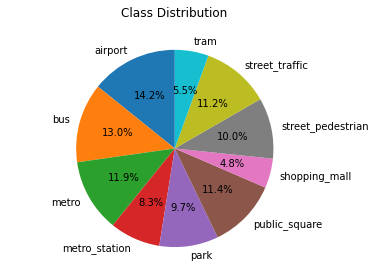

In [11]:
# To get Numbers Of Elements in Each Class
class_dist=df.groupby(['scene_label'])['length'].size()

fig,ax=plt.subplots()
ax.set_title("Class Distribution", y=1.08)
ax.pie(class_dist,labels=class_dist.index,autopct="%1.1f%%", shadow=False,startangle=90)
ax.axis('equal')
plt.show()

# **Creating Dataset using audio files**

In [ ]:
def save_mfcc(audio_path,data_frame,json_path, n_mfcc=13, n_fft=2048, hop_length=512,num_segments=10):
  mp=["airport","tram","bus","park","metro","metro_station","public_square","shopping_mall","street_pedestrian","street_traffic"]
  sample_rate=44100
  duration=10
  num_samples_per_segment=int((duration*sample_rate)/num_segments)
  expected_mfcc=math.ceil(num_samples_per_segment/hop_length)

  data={
      "mapping": mp,
      "mfcc": [],
      "labels": []
  }
  num_data=data_frame['filename'].size
  for i in range(0,num_data):
    semantic_label=data_frame.iloc[i][1]
    file_path=audio_path+df.iloc[i][0]
    signal,sr=librosa.load(file_path,sr=sample_rate)
    for s in range(num_segments):
      start_sample=int(num_samples_per_segment*s)
      end_sample=int(start_sample+num_samples_per_segment)
      mfcc=librosa.feature.mfcc(signal[start_sample:end_sample],
                                sr=sample_rate,
                                n_fft=n_fft,
                                n_mfcc=n_mfcc,
                                hop_length=hop_length).T
      if len(mfcc)==expected_mfcc:
        data["mfcc"].append(mfcc.tolist())
        data["labels"].append(mp.index(semantic_label))
  
  with open(json_path,"w") as fp:
    json.dump(data,fp,indent=4)


      


In [12]:
json_path=audio_path+"data.json"
# save_mfcc(audio_path,df,json_path, n_mfcc=13, n_fft=2048, hop_length=512,num_segments=10)

# **Loading Data and spliting  it into train and test set**

In [13]:
def load_data(dataset_path):
  with open( dataset_path,"r") as fp:
    data=json.load(fp)

  inputs=np.array(data["mfcc"])
  targets=np.array(data["labels"])
  return inputs,targets
inputs,targets=load_data(json_path)


In [14]:
type(inputs[0])

numpy.ndarray

In [15]:
def plot_history(history):

  fig,axs=plt.subplots(2)

  # Accuracy Subplot
  axs[0].plot(history.history["accuracy"],label="train accuracy")
  axs[0].plot(history.history["val_accuracy"],label="test accuracy")
  axs[0].set_ylabel("Accuracy")
  axs[0].legend(loc="lower right")
  axs[0].set_title("Accuracy Eval")

  # Error Subplot
  axs[1].plot(history.history["loss"],label="train error")
  axs[1].plot(history.history["val_loss"],label="test error")
  axs[1].set_ylabel("Error")
  axs[1].set_xlabel("Epoch")
  axs[1].legend(loc="upper right")
  axs[1].set_title("Error Eval")
  
  plt.show()

# **Creating a 1D CNN Model**

In [ ]:

inputs_train,inputs_test,targets_train,targets_test=train_test_split(inputs,targets,test_size=0.3)

model=keras.Sequential([
  #Input Layer
  keras.layers.Flatten(input_shape=(inputs.shape[1],inputs.shape[2])),

  #1st Hidden Layer
  keras.layers.Dense(512, activation="relu", kernel_regularizer=keras.regularizers.l2(0.0001)),
  keras.layers.Dropout(0.3),

  #2nd Hidden Layer
  keras.layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(0.0001)),
  keras.layers.Dropout(0.3),

  #3rd Hidden Layer
  keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.0001)),
  keras.layers.Dropout(0.3),
  
  #Output Layer
  keras.layers.Dense(10, activation="softmax")

])

optimizer=keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"]
              )

history=model.fit(inputs_train,targets_train,
          validation_data=(inputs_test,targets_test),
          epochs=50,
          batch_size=32,
          )


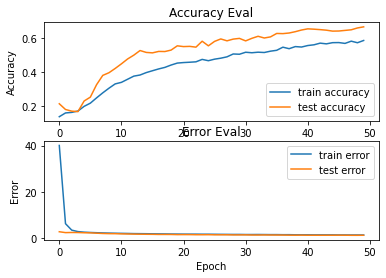

In [ ]:
plot_history(history)

# **Creating a 2D CNN Model**

In [71]:
def Lenet(inputs_shape):
  
    model = keras.models.Sequential([
                                     
    keras.layers.Conv2D(6, kernel_size=3, strides=1,  activation='relu', input_shape=inputs_shape, padding='same'), #C1

    keras.layers.AveragePooling2D(), #S2

    keras.layers.Conv2D(16, kernel_size=3, strides=1, activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.0001)), #C3
    keras.layers.Dropout(0.3),

    keras.layers.AveragePooling2D(), #S4

    keras.layers.Conv2D(120, kernel_size=3, strides=1, activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.0001)), #C5
    keras.layers.Dropout(0.3),

    keras.layers.Flatten(), #Flatten

    keras.layers.Dense(84, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001)), #F6
    
    keras.layers.Dense(10, activation='softmax') #Output layer
    ])
    return model

Epoch 1/5
178/178 [==============================] - 11s 58ms/step - loss: 2.5022 - accuracy: 0.1842 - val_loss: 1.9650 - val_accuracy: 0.3016
Epoch 2/5
178/178 [==============================] - 8s 44ms/step - loss: 2.0120 - accuracy: 0.2911 - val_loss: 1.7631 - val_accuracy: 0.3869
Epoch 3/5
178/178 [==============================] - 8s 44ms/step - loss: 1.8012 - accuracy: 0.3671 - val_loss: 1.5699 - val_accuracy: 0.4510
Epoch 4/5
178/178 [==============================] - 8s 44ms/step - loss: 1.6492 - accuracy: 0.4101 - val_loss: 1.4692 - val_accuracy: 0.4722
Epoch 5/5
178/178 [==============================] - 8s 44ms/step - loss: 1.5424 - accuracy: 0.4445 - val_loss: 1.3983 - val_accuracy: 0.4982


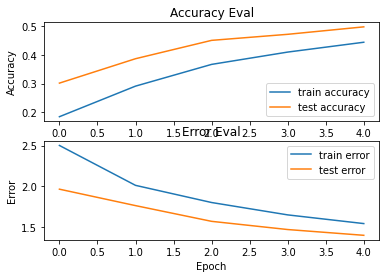

In [73]:
inputs_train,inputs_test,targets_train,targets_test=train_test_split(inputs,targets,test_size=0.3)
inputs_train,inputs_validation,targets_train,targets_validation=train_test_split(inputs_train,targets_train,test_size=0.2)
inputs_train=inputs_train[...,np.newaxis]
inputs_test=inputs_test[...,np.newaxis]
inputs_validation=inputs_validation[...,np.newaxis]
inputs_shape=(inputs_train.shape[1],inputs_train.shape[2],inputs_train.shape[3])

Model=Lenet(inputs_shape)

optimizer=keras.optimizers.Adam(learning_rate=0.0001)
Model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"]
              )

history=Model.fit(inputs_train,targets_train,
          validation_data=(inputs_validation,targets_validation),
          epochs=5,
          batch_size=32,
          )
plot_history(history)


In [76]:
test_error,test_accuracy=model.evaluate(inputs_test,targets_test,verbose=1)
print(test_accuracy*100)

95/95 [==============================] - 1s 16ms/step - loss: 1.3392 - accuracy: 0.5169
51.69463753700256


# **Creating a RNN LSTM Model**

In [16]:
def create_model(input_shape):
  model=keras.models.Sequential()

  model.add(keras.layers.LSTM(64,input_shape=input_shape,return_sequences=True))
  model.add(keras.layers.LSTM(64))

  model.add(keras.layers.Dense(64,activation="relu"))
  model.add(keras.layers.Dropout(0.3))

  model.add(keras.layers.Dense(10,activation="softmax"))

  return model

In [31]:
inputs_train,inputs_test,targets_train,targets_test=train_test_split(inputs,targets,test_size=0.3)
inputs_train,inputs_validation,targets_train,targets_validation=train_test_split(inputs_train,targets_train,test_size=0.2)
input_shape=(inputs_train.shape[1],inputs_train.shape[2])

model=create_model(input_shape)

optimizer=keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"]
              )


(87, 13)

In [ ]:
history=model.fit(inputs_train,targets_train,
          validation_data=(inputs_validation,targets_validation),
          batch_size=16,
          epochs=5,
          )

In [ ]:
plot_history(history)

In [26]:
test_error,test_accuracy=model.evaluate(inputs_test,targets_test,verbose=1)
print(test_accuracy*100)

95/95 [==============================] - 2s 23ms/step - loss: 1.2056 - accuracy: 0.5801
58.01250338554382


In [27]:
def get_mfcc_sample(sample,n_mfcc=13, n_fft=2048, hop_length=512,num_segments=10):
  sample,sample_rate=librosa.load(sample,sr=44100)
  duration=10
  num_samples_per_segment=int((duration*sample_rate)/num_segments)
  expected_mfcc=math.ceil(num_samples_per_segment/hop_length)
  sample_mfcc=[]

  for s in range(num_segments):
      start_sample=int(num_samples_per_segment*s)
      end_sample=int(start_sample+num_samples_per_segment)
      mfcc=librosa.feature.mfcc(sample[start_sample:end_sample],
                                sr=sample_rate,
                                n_fft=n_fft,
                                n_mfcc=n_mfcc,
                                hop_length=hop_length).T
      sample_mfcc.append(mfcc.tolist())
  return sample_mfcc
  


In [69]:
def predict_sample(sample,model):
  sample_data_mfcc=np.array(get_mfcc_sample(sample, n_mfcc=13, n_fft=2048, hop_length=512,num_segments=10))
  mp=["airport","tram","bus","park","metro","metro_station","public_square","shopping_mall","street_pedestrian","street_traffic"]
  results=model.predict(sample_data_mfcc)
  val=[0]*10

  for i in range(9):
   val[np.argmax(results[i])]+=1
  print(mp[np.argmax(val)])


In [77]:
sample = ("/content/drive/MyDrive/Colab Notebooks/SummerProject/audio/airport-barcelona-0-15-a.wav")
predict_sample(sample,Model)





airport


# **Creating a CRNN Model**

In [ ]:
def CRNN2D(X_shape, nb_classes):
    '''
    Model used for evaluation in paper. Inspired by K. Choi model in:
    https://github.com/keunwoochoi/music-auto_tagging-keras/blob/master/music_tagger_crnn.py
    '''

    nb_layers = 3  # number of convolutional layers
    nb_filters = [64, 128, 128, 128]  # filter sizes
    kernel_size = (3, 3)  # convolution kernel size
    activation = 'relu'  # activation function to use after each layer
    pool_size = [(2, 2), (2, 2), (2, 2), (2, 2),
                 (2, 2)]  # size of pooling area

    # shape of input data (frequency, time, channels)
    input_shape = X_shape
    frequency_axis = 1
    time_axis = 2
    channel_axis = 3

    # Create sequential model and normalize along frequency axis
    model = keras.models.Sequential()
    model.add(BatchNormalization(axis=frequency_axis, input_shape=input_shape))

    # First convolution layer specifies shape
    model.add(Conv2D(nb_filters[0], kernel_size=kernel_size, padding='same',
                     data_format="channels_last",
                     input_shape=input_shape,
                     kernel_regularizer=keras.regularizers.l2(0.0001)))
    model.add(Activation(activation))
    model.add(BatchNormalization(axis=channel_axis))
    model.add(MaxPooling2D(pool_size=pool_size[0], strides=pool_size[0]))
    model.add(Dropout(0.3))

    # Add more convolutional layers
    for layer in range(nb_layers - 1):
        # Convolutional layer
        model.add(Conv2D(nb_filters[layer + 1], kernel_size=kernel_size,
                         padding='same',
                         kernel_regularizer=keras.regularizers.l2(0.0001)))
        model.add(Activation(activation))
        model.add(BatchNormalization(
            axis=channel_axis))  # Improves overfitting/underfitting
        model.add(MaxPooling2D(pool_size=pool_size[layer + 1],
                               strides=pool_size[layer + 1]))  # Max pooling
        model.add(Dropout(0.3))

        # Reshaping input for recurrent layer
    # (frequency, time, channels) --> (time, frequency, channel)
    model.add(Permute((time_axis, frequency_axis, channel_axis)))
    resize_shape = model.output_shape[2] * model.output_shape[3]
    model.add(Reshape((model.output_shape[1], resize_shape)))

    # recurrent layer
    model.add(GRU(32, return_sequences=True))
    model.add(GRU(32, return_sequences=False))
    model.add(Dropout(0.2))

    # Output layer
    model.add(Dense(nb_classes))
    model.add(Activation("softmax"))
    return model

In [ ]:
inputs_train,inputs_test,targets_train,targets_test=train_test_split(inputs,targets,test_size=0.3)
inputs_train,inputs_validation,targets_train,targets_validation=train_test_split(inputs_train,targets_train,test_size=0.2)
inputs_train=inputs_train[...,np.newaxis]
inputs_test=inputs_test[...,np.newaxis]
inputs_validation=inputs_validation[...,np.newaxis]
inputs_shape=(inputs_train.shape[1],inputs_train.shape[2],inputs_train.shape[3])

model=CRNN2D(inputs_shape,10)

optimizer=keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"]
              )

In [ ]:
optimizer=keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"]
              )

history=model.fit(inputs_train,targets_train,
          validation_data=(inputs_validation,targets_validation),
          epochs=50,
          batch_size=16,
          )
plot_history(history)

In [ ]:
test_error,test_accuracy=model.evaluate(inputs_test,targets_test,verbose=1)
print(test_accuracy*100)

# **Predicting From a Sound Sample**


In [2]:
def get_mfcc_sample(sample,n_mfcc=13, n_fft=2048, hop_length=512,num_segments=10):
  sample,sample_rate=librosa.load(sample,sr=44100)
  duration=10
  num_samples_per_segment=int((duration*sample_rate)/num_segments)
  expected_mfcc=math.ceil(num_samples_per_segment/hop_length)
  sample_mfcc=[]

  for s in range(num_segments):
      start_sample=int(num_samples_per_segment*s)
      end_sample=int(start_sample+num_samples_per_segment)
      mfcc=librosa.feature.mfcc(sample[start_sample:end_sample],
                                sr=sample_rate,
                                n_fft=n_fft,
                                n_mfcc=n_mfcc,
                                hop_length=hop_length).T
      # if len(mfcc)==expected_mfcc:
      sample_mfcc.append(mfcc.tolist())
  return sample_mfcc
  



13